# Red Line Detection and Tracking in Video

This notebook detects and tracks the intersection of the red lines in the video.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from tqdm.notebook import tqdm

## Load and Prepare Video

`cap` defines the video source, which can be a file path or a camera index. 

In [2]:
os.makedirs('tmp', exist_ok=True)
video_path = 'tmp/shake.mp4'
url = 'https://nist-assets.s3.us-east-1.amazonaws.com/shake.mp4'
with open(video_path, 'wb') as f:
    f.write(requests.get(url).content)

cap = cv2.VideoCapture(video_path)

## Guide Frame

Loading frames:   0%|          | 0/297 [00:00<?, ?frames/s]

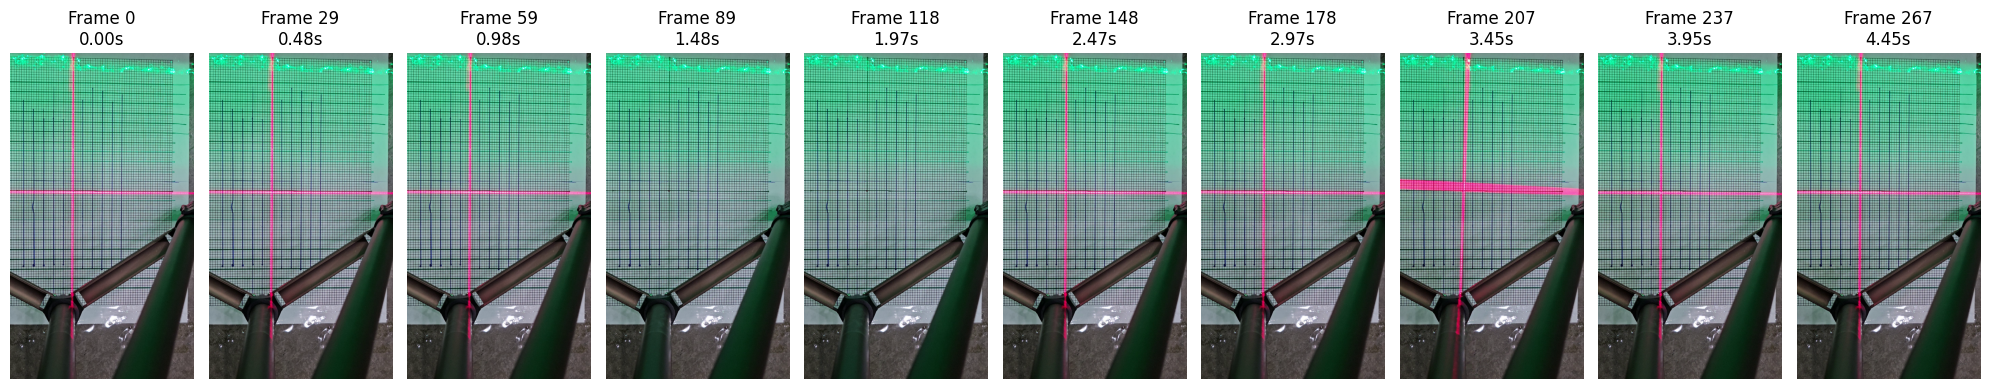

In [3]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

num_ref_frames = 10
frame_indices = [int(i * frame_count / num_ref_frames) for i in range(num_ref_frames)]

all_frames, selected_frames = [], []
for idx in tqdm(range(frame_count), unit="frames", desc='Loading frames'):
    ret, frame = cap.read()
    if not ret: break
    rotated = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
    all_frames.append(frame_rgb)
    if idx in frame_indices:
        selected_frames.append(frame_rgb)
cap.release()

def plot_frames(frames, titles):
    fig, axes = plt.subplots(1, len(frames), figsize=(20, 4))
    for ax, frame, title in zip(axes, frames, titles):
        ax.imshow(frame)
        ax.axis('off')
        ax.set_title(title)
    fig.tight_layout()
    fig.show()

plot_frames(selected_frames, [f'Frame {idx}\n{idx / fps:.2f}s' for idx in frame_indices])

### Select Guide Frame

`guide_frame_idx` defines the frame to use as a reference for per frame image processing.

In [4]:
guide_frame_idx = 0

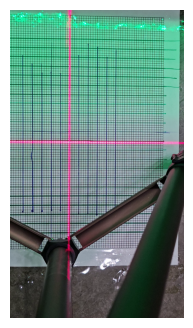

In [5]:
guide_frame = all_frames[guide_frame_idx]
frame_hsv = cv2.cvtColor(guide_frame.copy(), cv2.COLOR_RGB2HSV)

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(guide_frame)
ax.axis('off')
fig.show()

## Define HSV Hue Range for Red Detection

`start_hue` and `end_hue` define the red hue range.
`s_min` and `s_max` define the saturation range.
`v_min` and `v_max` define the value/brightness range.

In [6]:
start_hue, end_hue = 145, (145 + 45) % 180
s_min, s_max = 100, 255
v_min, v_max = 100, 255

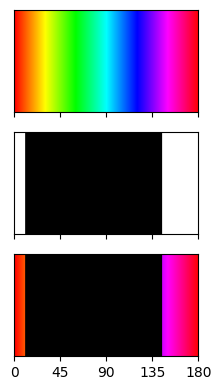

In [7]:
def show_hue_range(start, end, s_min=100, s_max=255, v_min=100, v_max=255, axes=None):
    height, width = 100, 180
    h = np.linspace(0, 179, width, dtype=np.uint8)
    s = np.full(height, s_max, dtype=np.uint8)
    v = np.full(height, v_max, dtype=np.uint8)
    hsv_img = np.stack([np.tile(h, (height, 1)),
                        np.tile(s[:, None], (1, width)),
                        np.tile(v[:, None], (1, width))], axis=-1).astype(np.uint8)

    if start < end:
        lower, upper = np.array([start, s_min, v_min]), np.array([end, s_max, v_max])
        mask = cv2.inRange(hsv_img, lower, upper)
        bounds = [[lower, upper]]
    else:
        mask1 = cv2.inRange(hsv_img, np.array([start, s_min, v_min]), np.array([179, s_max, v_max]))
        mask2 = cv2.inRange(hsv_img, np.array([0, s_min, v_min]), np.array([end, s_max, v_max]))
        mask = cv2.bitwise_or(mask1, mask2)
        bounds = [[np.array([start, s_min, v_min]), np.array([179, s_max, v_max])],
                  [np.array([0, s_min, v_min]), np.array([end, s_max, v_max])]]

    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    result = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)

    for i, img in enumerate([rgb_img, mask, result]):
        axes[i].imshow(img if i != 1 else img, cmap='gray' if i == 1 else None)
        axes[i].set_yticks([]); axes[i].set_xticks([0, 45, 90, 135, 180])

    return bounds

fig, ax = plt.subplots(3, 1, figsize=(15, 4), sharex=True)
hue_range = show_hue_range(start=start_hue, end=end_hue, 
                           s_min=s_min, s_max=s_max, 
                           v_min=v_min, v_max=v_max, 
                           axes=ax)
fig.tight_layout()

## Line Detection Utilities

In [8]:
def get_red_mask(hsv_img, bounds):
    masks = [cv2.inRange(hsv_img, lower, upper) for lower, upper in bounds]
    return cv2.bitwise_or(*masks)

def draw_fitted_line(img, params, color, length=4000, thickness=8):
    if params is None: return
    vx, vy, x0, y0 = params
    pt1 = (int(x0 - length * vx), int(y0 - length * vy))
    pt2 = (int(x0 + length * vx), int(y0 + length * vy))
    cv2.line(img, pt1, pt2, color, thickness)

def separate_lines(lines):
    horiz, vert = [], []
    for [[x1, y1, x2, y2]] in lines:
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        (horiz if -20 < angle < 20 else vert if 70 < abs(angle) < 110 else []).append((x1, y1, x2, y2))
    return horiz, vert

def fit_line(lines):
    if not lines: return None
    pts = np.array([[[x, y]] for line in lines for x, y in [line[:2], line[2:]]])
    return cv2.fitLine(pts, cv2.DIST_L2, 0, 0.01, 0.01).flatten()

def compute_intersection(v1, v2):
    try:
        A = np.array([[v1[0], -v2[0]], [v1[1], -v2[1]]])
        b = np.array([v2[2] - v1[2], v2[3] - v1[3]])
        t, _ = np.linalg.solve(A, b)
        return int(v1[2] + t * v1[0]), int(v1[3] + t * v1[1])
    except np.linalg.LinAlgError:
        return None

## Process Video Frames and Track Red Line Intersections

`gaussian_kernel_size` controls the Gaussian blur applied to the red mask.
`canny_threshold1` and `canny_threshold2` control the Canny edge detection sensitivity.
`hough_threshold` is the threshold for Hough line detection.
`hough_min_line_length` and `hough_max_line_gap` control the minimum line length and maximum gap for Hough line detection.

After processing the frames, frames with less than 1% of "red" pixels are skipped assuming there is not laser present. Any frames with detected lines but no intersection are assumed to have failed in processing are displayed for debugging.

In [9]:
gaussian_kernel_size = (101, 101)
canny_threshold1 = 5
canny_threshold2 = 30

hough_threshold = 30
hough_minLineLength = 500
hough_maxLineGap = 50

Processing frames:   0%|          | 0/297 [00:00<?, ?frames/s]

Processed 297 frames. Skipped: 60, Failed: 0


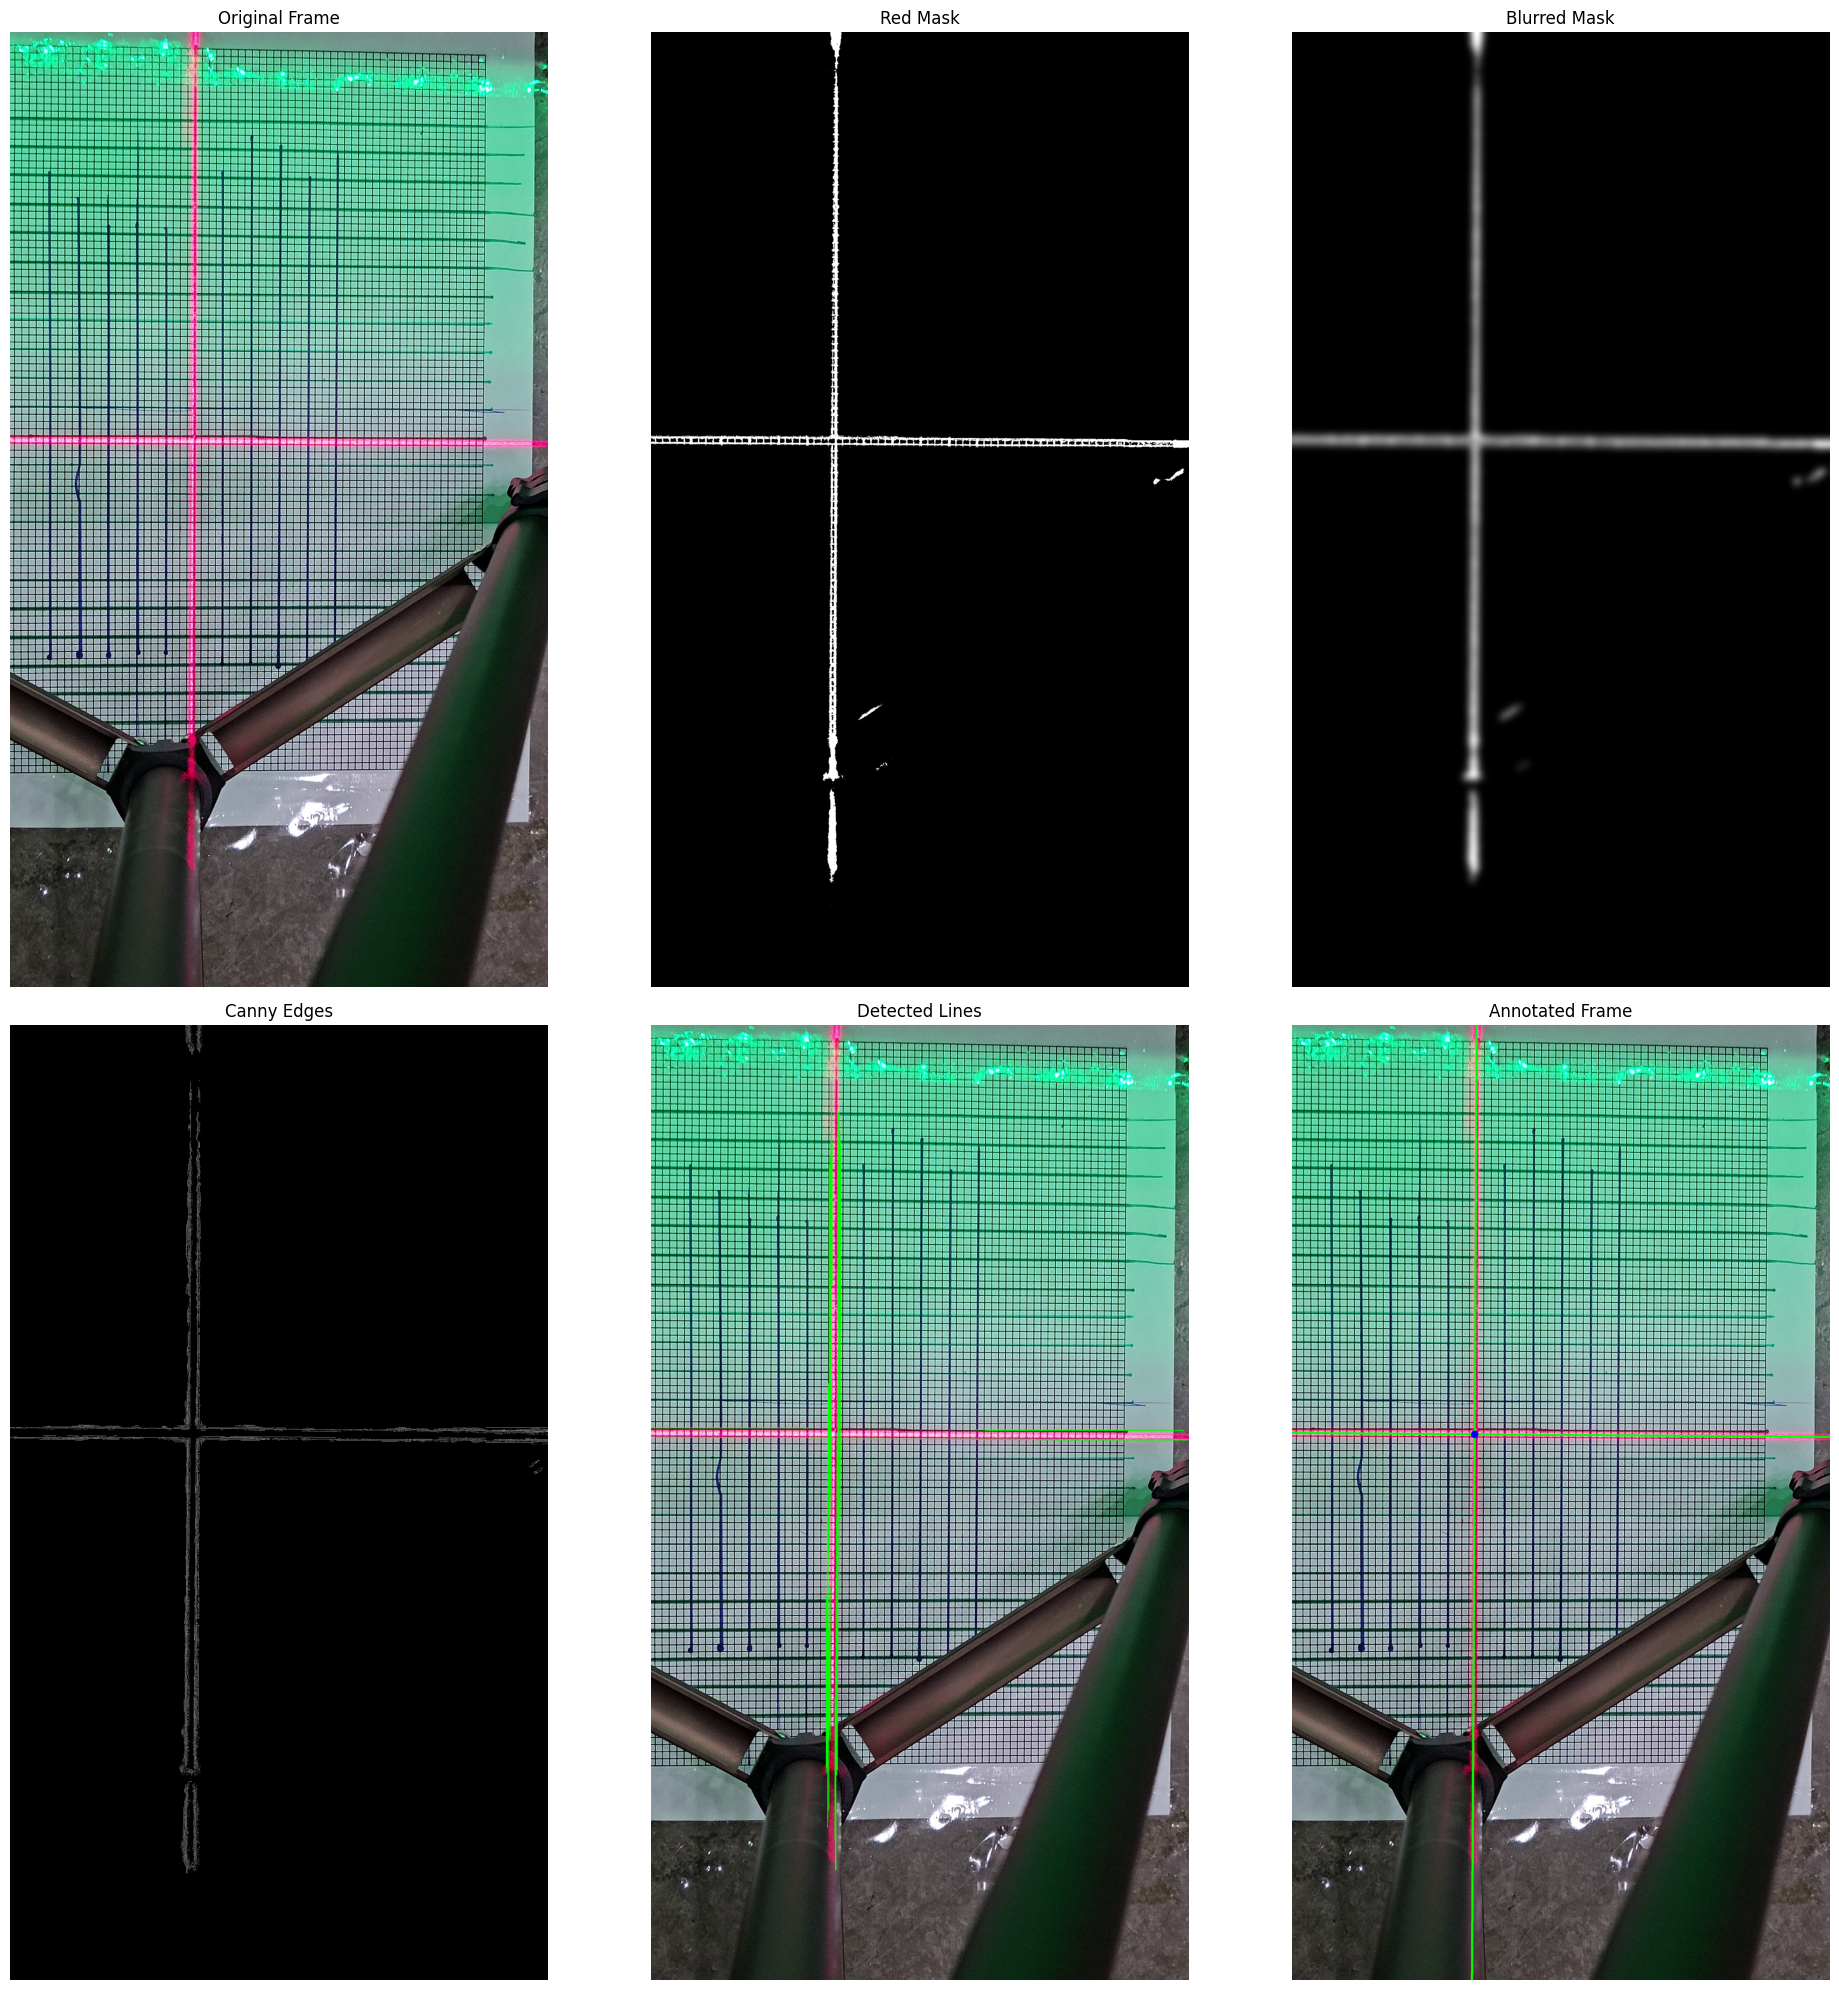

In [10]:
h, w = all_frames[0].shape[:2]
video_out = cv2.VideoWriter('tmp/output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

intersection_points, skipped_frames, failing_frames = [], [], []
red_pixel_percentages = []

for i, frame_rgb in tqdm(enumerate(all_frames), total=len(all_frames), unit="frames", desc="Processing frames"):
    hsv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2HSV)
    red_mask = get_red_mask(hsv, hue_range)
    red_pct = 100 * cv2.countNonZero(red_mask) / (h * w)
    red_pixel_percentages.append(red_pct)

    if red_pct < 1.0:
        intersection_points.append(None)
        skipped_frames.append(i)
        video_out.write(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
        continue

    blurred = cv2.GaussianBlur(red_mask, gaussian_kernel_size, sigmaX=0)
    edges = cv2.Canny(blurred, canny_threshold1, canny_threshold2)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, hough_threshold, minLineLength=hough_minLineLength, maxLineGap=hough_maxLineGap)

    horiz, vert = separate_lines(lines) if lines is not None else ([], [])
    fitted_h, fitted_v = fit_line(horiz), fit_line(vert)
    inter_pt = compute_intersection(fitted_h, fitted_v) if (fitted_h is not None and fitted_v is not None) else None

    if inter_pt is None and red_pct >= 1.0:
        failing_frames.append(i)

    intersection_points.append(inter_pt)
    annotated = frame_rgb.copy()
    draw_fitted_line(annotated, fitted_h, (0, 255, 0))
    draw_fitted_line(annotated, fitted_v, (0, 255, 0))
    if inter_pt: cv2.circle(annotated, inter_pt, 15, (0, 0, 255), -1)
    video_out.write(cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
    
    if i == guide_frame_idx:
        frame_lines_overlay = frame_rgb.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(frame_lines_overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)

        fig, axes = plt.subplots(2, 3, figsize=(20, 20))
        axes[0, 0].imshow(frame_rgb)
        axes[0, 0].axis('off')
        axes[0, 0].set_title('Original Frame')
        
        axes[0, 1].imshow(red_mask, cmap='gray')
        axes[0, 1].axis('off')
        axes[0, 1].set_title('Red Mask')
        
        axes[0, 2].imshow(blurred, cmap='gray')
        axes[0, 2].axis('off')
        axes[0, 2].set_title('Blurred Mask')
        
        axes[1, 0].imshow(edges, cmap='gray')
        axes[1, 0].axis('off')
        axes[1, 0].set_title('Canny Edges')
        
        axes[1, 1].imshow(frame_lines_overlay)
        axes[1, 1].axis('off')
        axes[1, 1].set_title('Detected Lines')
        
        axes[1, 2].imshow(annotated)
        axes[1, 2].axis('off')
        axes[1, 2].set_title('Annotated Frame')
        
        fig.tight_layout()

video_out.release()
print(f"Processed {len(intersection_points)} frames. Skipped: {len(skipped_frames)}, Failed: {len(failing_frames)}")

### Visualize Failing Frames

In [11]:
if failing_frames:
    rows, cols = -(-len(failing_frames) // 4), min(len(failing_frames), 4)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 10 * rows))
    axes = axes.flatten() if rows > 1 else [axes]
    for ax, idx in zip(axes, failing_frames):
        ax.imshow(all_frames[idx])
        ax.set_title(f"Frame {idx}")
        ax.axis('off')
    for ax in axes[len(failing_frames):]: ax.axis('off')
    fig.tight_layout()
    fig.show()
else:
    print("All frames have valid intersections.")

All frames have valid intersections.


## Plot Intersection Path Over Time

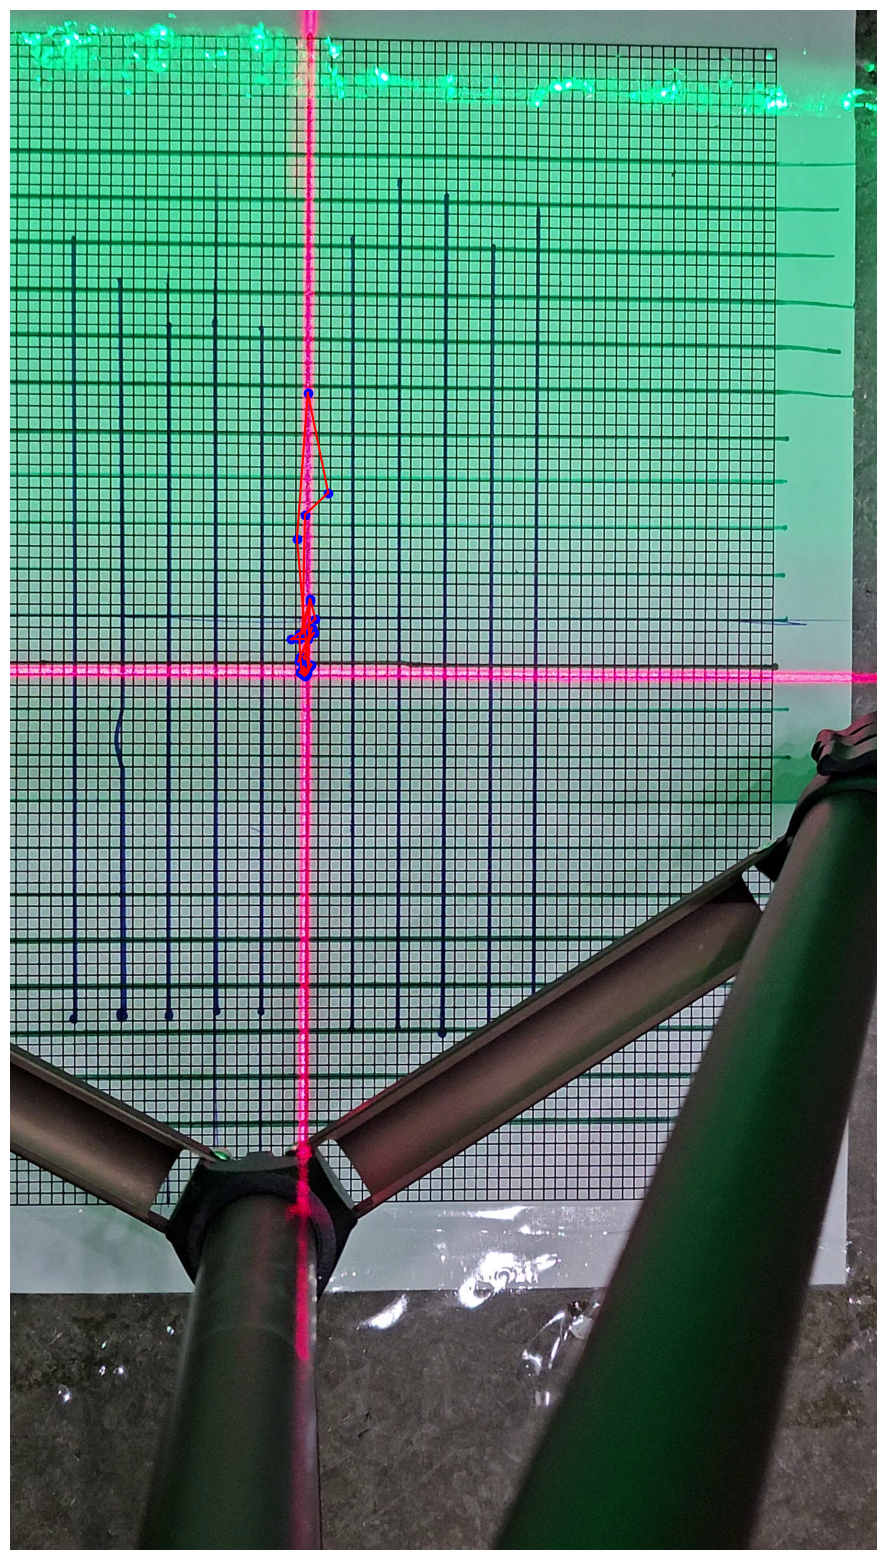

In [13]:
valid = [(i, pt) for i, pt in enumerate(intersection_points) if pt]
indices, pts = zip(*valid)
x_vals, y_vals = zip(*pts)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(all_frames[-1])
ax.scatter(x_vals, y_vals, c='blue')

for i in range(len(indices) - 1):
    if indices[i+1] == indices[i] + 1:
        ax.plot([x_vals[i], x_vals[i+1]], [y_vals[i], y_vals[i+1]], c='red')

ax.axis('off')
fig.show()